In [ ]:
#!pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
#!pip install facenet_pytorch
#!pip install opencv-python
#!pip install numpy
#!pip install pillow

In [148]:
from PIL import Image 
from tqdm.auto import tqdm

import torch
import numpy as np
import cv2

from facenet_pytorch import MTCNN

video_path = 'data/video_face_tracking.mp4'
write_path = 'data/video_face_tracking_out.avi'

fd = MTCNN()
# video_path 경로에 있는 비디오영상을 frame별로 반환해주는 함수 
def get_frames(video_path = video_path):
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, img = cap.read()
        if not ret:
            cap.release()
            return None
        yield img[:,:,[2,1,0]].copy()
        
# frame이미지들을 하나의 비디오영상으로 만들어 특정경로에 저장해주는 함수
def write_frames(imgs, write_path = write_path):
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    h, w = imgs[0].shape[:2]
    out = cv2.VideoWriter(write_path, fourcc, 10.0, (w, h))
    
    for img in imgs:
        out.write(img[:,:,[2,1,0]].copy())
    out.release()
    
# batch 의 개수만큼의 이미지에서 사람얼굴에 해당하는 박스정보와 해당 얼굴의 일치율를 반환해주는 함수
def detect(batchs):
    for batch in batchs:
        fs, ps = fd.detect(list(batch))
        for face_boxes, probs in zip(fs, ps):
            yield face_boxes, probs

In [149]:
from IPython.display import Video
Video(video_path, width=512)

In [150]:
frames = [frame for frame in get_frames()] # 비디오의 frame들(105개)
batchs = np.array_split(frames, 20) # 각 frames 들을 20개씩 나눈다(array_split 참조)

In [151]:
frame_infos = detect(batchs)
frame_infos = tqdm(frame_infos, total=len(frames))
frame_infos = list(frame_infos)

In [152]:
# img에서 box에 해당하는 위치에 tuple_rgb 색으로 사각형과 prob확률수치를 그리는 함수
def draw_boxes_with_color(img, box, prob, tuple_rgb):
    if type(tuple_rgb) == tuple:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), color=tuple_rgb, thickness=4)
        cv2.putText(img, str(prob), (x1, int(y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, tuple_rgb, 2)
        return img

In [153]:
# 현 프레임에서 가장 얼굴 일치율이 높은 사람의 얼굴에 녹색 사각형, 확률을 그리고
# 나머지 얼굴에는 붉은색 사각형, 확률을 그리는 함수
def draw_boxes(img, box, prob):
    max_prob_i = np.argmax(prob)
    for i in range(0, len(box)):
        if i == max_prob_i:
            draw_boxes_with_color(img, box[i], prob[i], (0, 255, 0))
        else:
            draw_boxes_with_color(img, box[i], prob[i], (255, 0, 0))
    return img

In [154]:
# 모든 프레임 이미지에 draw_boxes함수를 적용한 뒤에 작업한 이미지들을 모은다.
imgs = [draw_boxes(img, box, prob) for img, (box, prob) in zip(frames, frame_infos)]

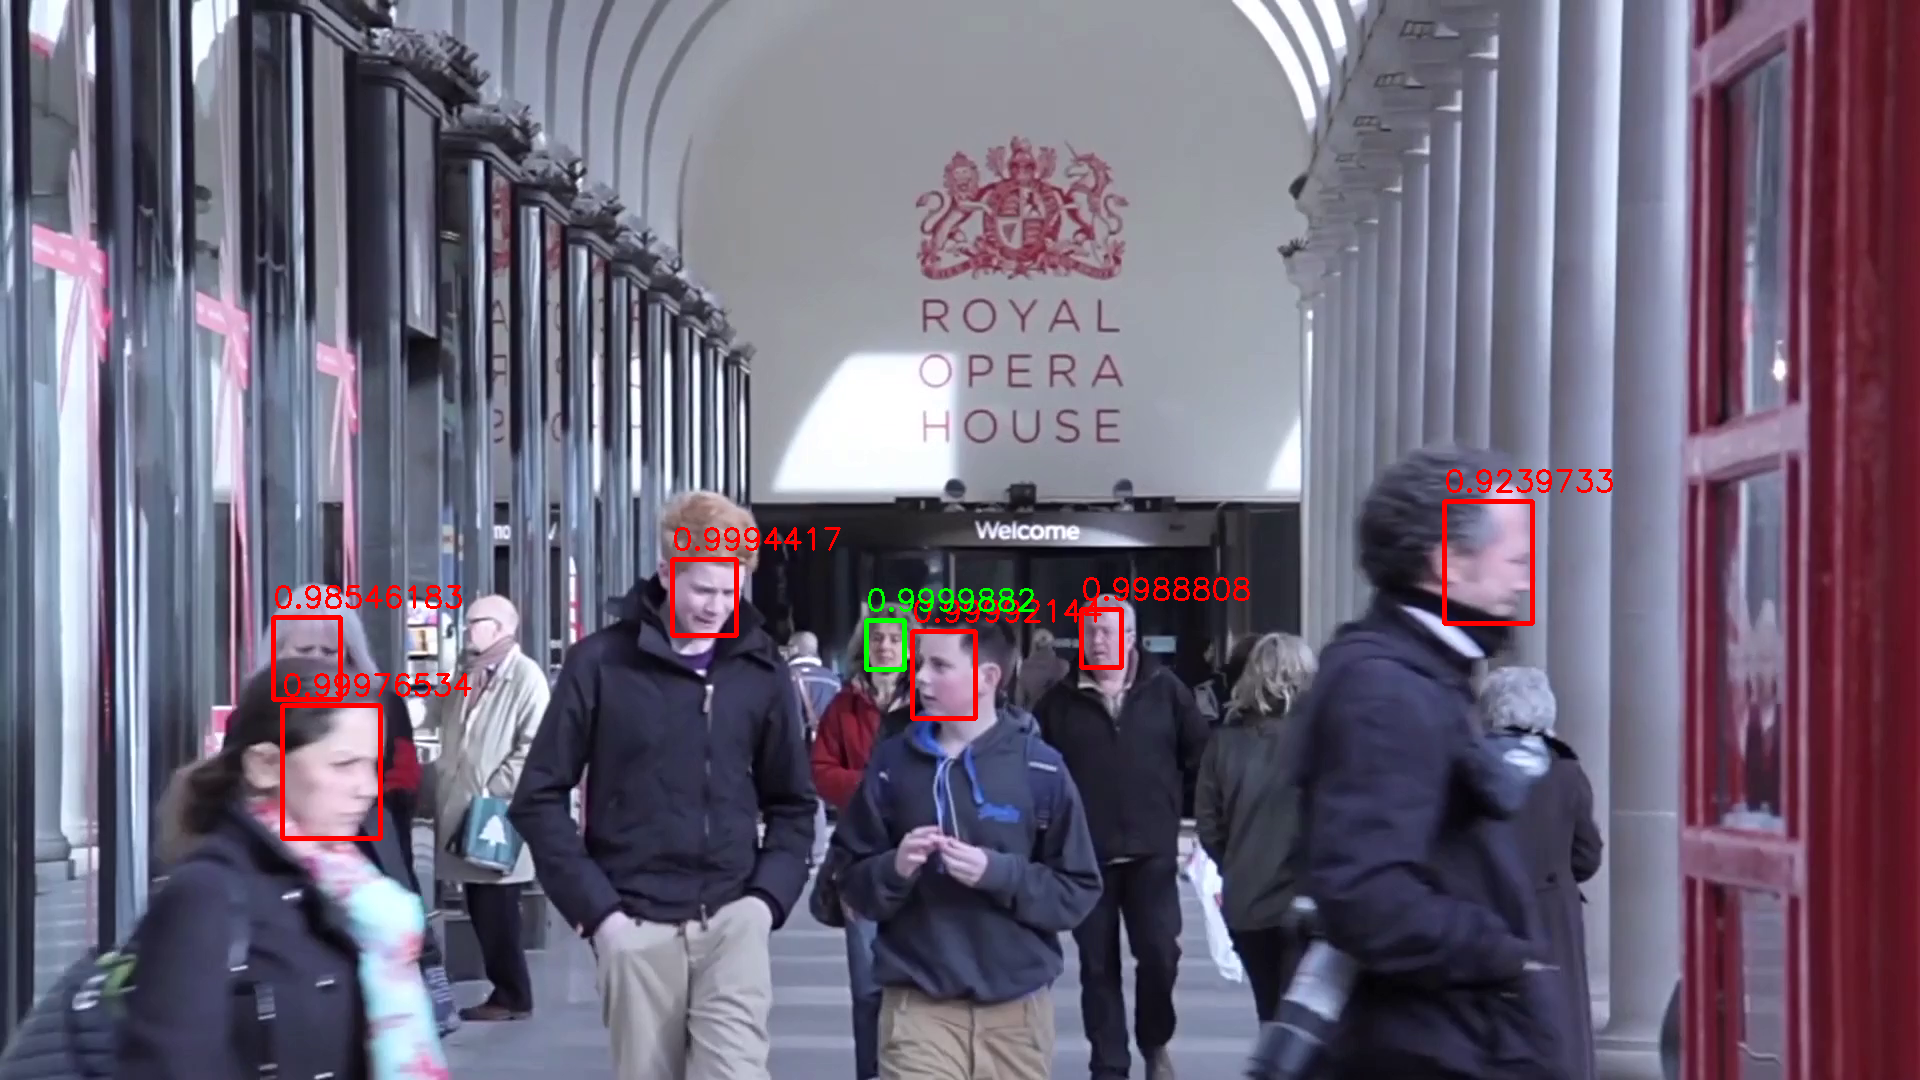

In [155]:
Image.fromarray(imgs[0])

In [156]:
write_frames(imgs)

---
## 숙제
  
1. 이 노트북을 실행시켜 ./data/video_face_tracking_out.avi 파일을 생성하고 곰플레이어 등으로 열어서 감상하세요.
     
2. 이 노트북의 모든 코드셀을 분석 후 적당히 주석을 달아 주세요.   

3. 출력 동영상은 사람들 얼굴에 붉은 박스로 표시를 했는데요
   각 프레임별로 가장 확률이 높게 예측한 박스는 녹색으로 표기해 주세요.  
   (나머지 박스는 기존과 같이 붉은색으로 표기하면 됩니다)
   
4. *remind* 각자 Numpy를 마스터 하세요.  유튜브와 관련책을 참고하면 좋습니다.